# Tehtävä 6 - Klusterointimenetelmät k-means, Mean-Shift ja DBSCAN
Hannu Karstu - TTV19SAI

## Tehtävänanto
Lataa wholesale customers data.csv oheisen linkin kautta http://archive.ics.uci.edu/ml/datasets/
Wholesale+customers. Luo Notebookiisi datasets niminen kansio ja siirrä tiedosto wholesale customers data.csv sen sisään.

## Data preprocessing

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [2]:
data = pd.read_csv("datasets/wholesale_customers_data.csv")

In [3]:
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [4]:
outliers = {}
for i in range(data.shape[1]):
    min_t = data[data.columns[i]].mean() - (3 * data[data.columns[i]].std())
    max_t = data[data.columns[i]].mean() + (3 * data[data.columns[i]].std())
    count = 0
    for j in data[data.columns[i]]:
        if j < min_t or j > max_t:
            count += 1
    outliers[data.columns[i]] = [count,data.shape[0]-count]
print(outliers)

{'Channel': [0, 440], 'Region': [0, 440], 'Fresh': [7, 433], 'Milk': [9, 431], 'Grocery': [7, 433], 'Frozen': [6, 434], 'Detergents_Paper': [10, 430], 'Delicassen': [4, 436]}


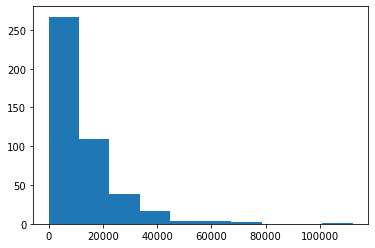

In [5]:
plt.hist(data["Fresh"])
plt.show()

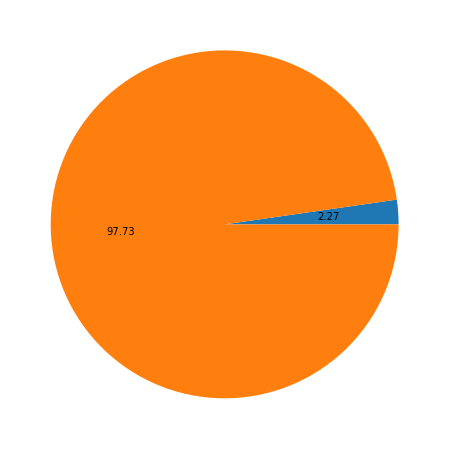

In [6]:
plt.figure(figsize=(8,8))
plt.pie(outliers["Detergents_Paper"],autopct="%.2f")
plt.show()

In [7]:
data_standardized = (data - data.mean())/data.std()
data_standardized.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.447005,0.589997,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,1.447005,0.589997,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050
2,1.447005,0.589997,-0.446521,0.408073,-0.028125,-0.137379,0.133080,2.240742
3,-0.689512,0.589997,0.099998,-0.623310,-0.392530,0.686363,-0.498021,0.093305
4,1.447005,0.589997,0.839284,-0.052337,-0.079266,0.173661,-0.231654,1.297870


## k-means algorithm

In [8]:
from sklearn.cluster import KMeans

In [9]:
ideal_k = []
for i in range(1,15):
    est_kmeans = KMeans(n_clusters=i)
    est_kmeans.fit(data_standardized)
    
    ideal_k.append([i,est_kmeans.inertia_])

In [10]:
ideal_k = np.array(ideal_k)

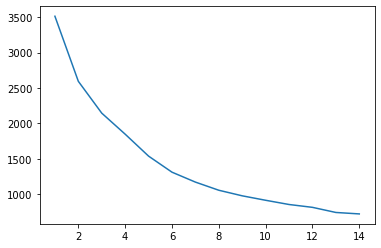

In [11]:
plt.plot(ideal_k[:,0],ideal_k[:,1])
plt.show()

### Tehtävä 1: Valitse sopiva k:n arvo hyödyntäen yllä olevaa kuvaajaa

- Tässä tehtävässä pitäisi edellisen viikon tehtävän mukaisesti katsoa graafia ja löytää sieltä niin sanottu kyynärpää. Sellainen havaitseminen on melko vaikeaa, mutta ehkä numero 2 olisi lähimpänä sitä.
- Se ettei kyynärpäätä näy selvästi, tarkoittaa että data ei ole niin selkeästi klusteroituvaa.

In [12]:
est_kmeans = KMeans(n_clusters=2)
est_kmeans.fit(data_standardized)
pred_kmeans = est_kmeans.predict(data_standardized)

### Tehtävä 2: Toteuta alla olevaan tyhjään kohtaan Silhouette analysis kolmella eri k:n arvolla varmistuaksesi oikeasta k:n arvosta
Apuja saat täältä: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

**Käytän tässä edellisessä tehtävässä tekemääni silhouette scoren laskijaa**

In [13]:
from sklearn.metrics import silhouette_score

# Kerätään listoihin silhouette scoret ja k-lukumäärät, jotta ne voidaan plotata nätisti.
sil = []
kmax = 15
k_values = []

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data_standardized)
  labels = kmeans.labels_
  k_values.append(k)
  sil.append(silhouette_score(data_standardized, labels, metric = 'euclidean'))

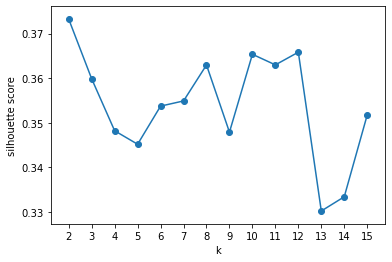

In [14]:
# Viiva
plt.plot(k_values,sil)

# Pallukat
plt.scatter(k_values,sil)

# Tekstit
plt.xlabel("k")
plt.xticks(k_values)
plt.ylabel("silhouette score")

plt.show()

- High Silhouette Score is desirable. The Silhouette Score reaches its global maximum at the optimal k. 

- Näyttäisi siltä että k-arvo 2 ja 12 ovat parhaat.

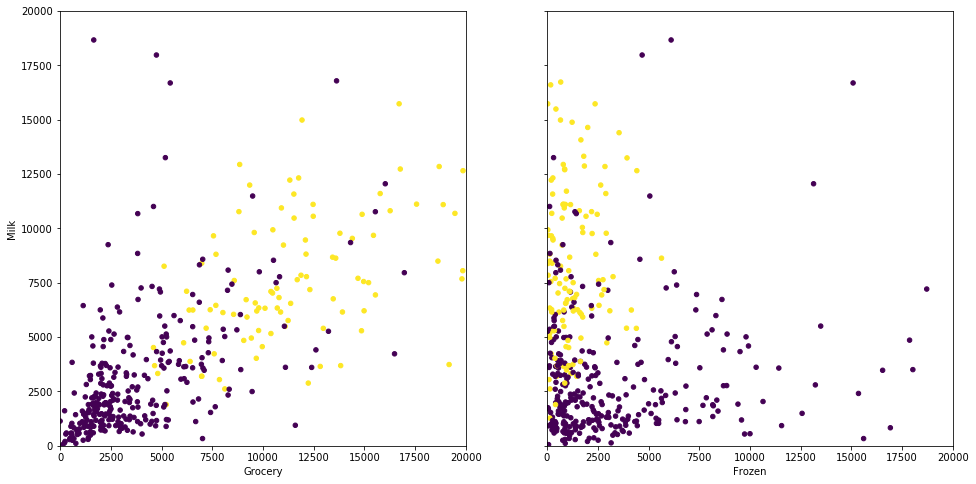

In [15]:
plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,8))
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_kmeans, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Frozen')
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_kmeans, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.show()

## Mean-Shift algorithm

In [16]:
from sklearn.cluster import MeanShift

In [17]:
est_meanshift = MeanShift(0.9)
est_meanshift.fit(data_standardized)
pred_meanshift = est_meanshift.predict(data_standardized)

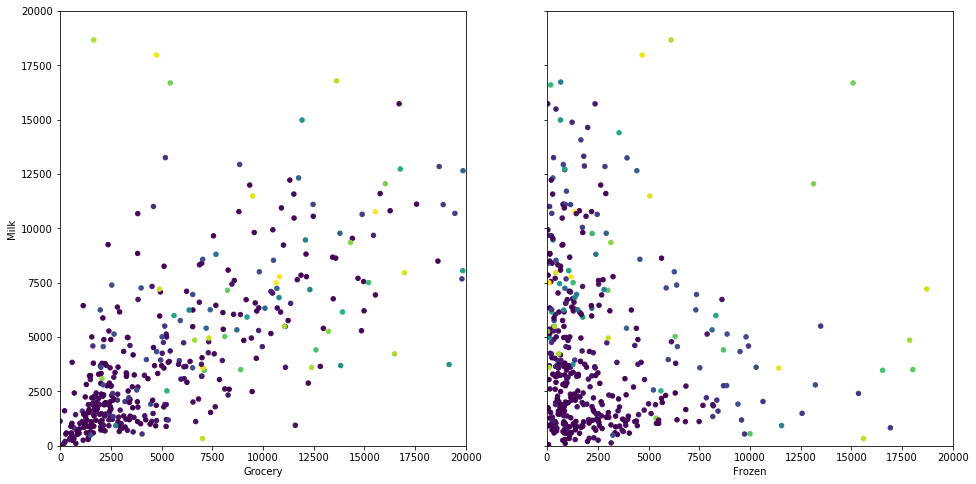

In [18]:
plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,8))
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_meanshift, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Frozen')
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_meanshift, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.show()

## DBSCAN algorithm

In [19]:
from sklearn.cluster import DBSCAN

In [20]:
est_dbscan = DBSCAN(eps=0.3)
pred_dbscan = est_dbscan.fit_predict(data_standardized)

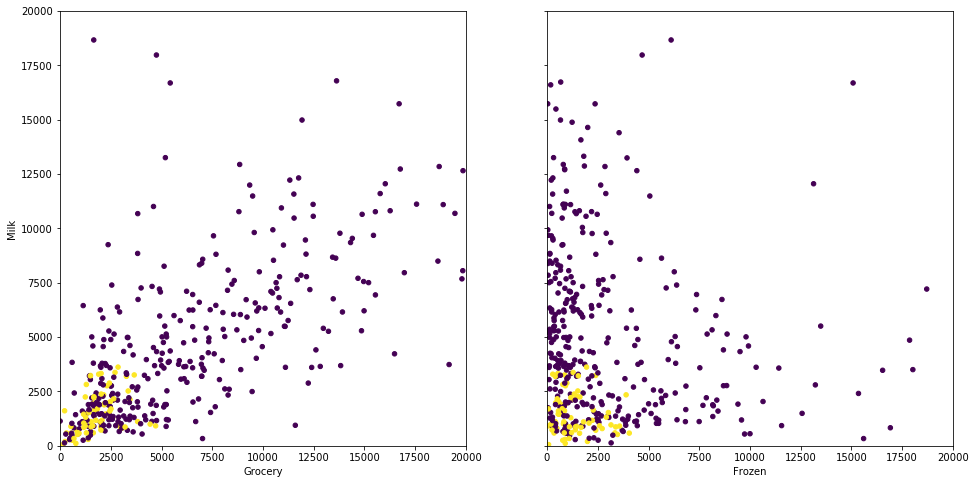

In [21]:
plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,8))
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Frozen')
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.show()

## Clustering performance evaluation

### Silhouette Score

In [22]:
from sklearn.metrics import silhouette_score

In [23]:
kmeans_score = silhouette_score(data_standardized, pred_kmeans, metric='euclidean')
meanshift_score = silhouette_score(data_standardized, pred_meanshift, metric='euclidean')
dbscan_score = silhouette_score(data_standardized, pred_dbscan, metric='euclidean')

print("SILHOUETTE SCORE")
print("kmeans:",kmeans_score)
print("meanshift:",meanshift_score)
print("dbscan:", dbscan_score)

SILHOUETTE SCORE
kmeans: 0.37323636511581165
meanshift: 0.1876897219797515
dbscan: -0.06439381509463221


- The best value is 1 and the worst value is -1. 
- Values near 0 indicate overlapping clusters. 
- Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

### Calinski and Harabasz Score

In [24]:
from sklearn.metrics import calinski_harabasz_score

In [25]:
kmeans_score = calinski_harabasz_score(data_standardized, pred_kmeans)
meanshift_score = calinski_harabasz_score(data_standardized, pred_meanshift)
dbscan_score = calinski_harabasz_score(data_standardized, pred_dbscan)

print("CALINSKI AND HARABASZ SCORE")
print("kmeans:",kmeans_score)
print("meanshift:",meanshift_score)
print("dbscan:", dbscan_score)

CALINSKI AND HARABASZ SCORE
kmeans: 155.12478460559308
meanshift: 59.1712718293517
dbscan: 25.38229485397911


- Calinski and Harabasz score is also known as the Variance Ratio Criterion.

- The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.



### Tehtävä 3: Varioi algoritmien Mean-Shift (bandwith) ja DBSCAN (eps) parametreja saadaksesi paremmat pisteet algoritmien suorituskyvyn evaluoinnista 

### Mean-Shift

In [26]:
# Luodaan funktio jotta testaaminen helpottuu

def meanshiftBandwidth(bandwidth):
    est_meanshiftB = MeanShift(bandwidth=bandwidth)
    est_meanshiftB.fit(data_standardized)
    pred_meanshiftB = est_meanshiftB.predict(data_standardized)
    return pred_meanshiftB

In [27]:
# Taulukko johon kerätään tulokset
meanshiftResults = []

# Ajetaan looppi ja kerätään tulokset taulukkoon
for i in range (1,11):
    pred = meanshiftBandwidth(i)
    meanshift_sil = silhouette_score(data_standardized, pred, metric='euclidean')
    meanshift_cal = calinski_harabasz_score(data_standardized, pred)
    meanshiftResults.append([i,meanshift_sil,meanshift_cal])

In [28]:
import pandas as pd

df = pd.DataFrame(data=meanshiftResults)
df = df.rename(columns={0: 'Bandwidth', 1: 'Silhouette_Score', 2: 'CH_score'})
df

,Bandwidth,Silhouette_Score,CH_score
0,1,0.222054,63.011110
1,2,0.296230,58.188844
2,3,0.464489,30.495432
3,4,0.531675,35.849168
4,5,0.605626,55.913265
5,6,0.676233,38.836380
6,7,0.826351,48.882614
7,8,0.826351,48.882614
8,9,0.826351,48.882614
9,10,0.826351,48.882614


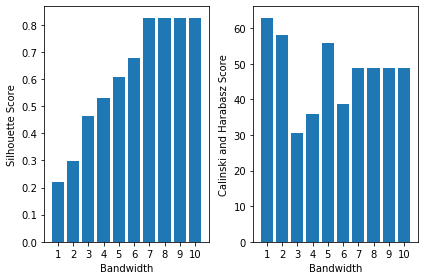

In [29]:
# Plotataan tulokset näkyville:

%matplotlib inline
import matplotlib.pyplot as plt

# Vasen puoli
plt.subplot(1, 2, 1)
plt.bar(df['Bandwidth'],df['Silhouette_Score'])
plt.xlabel("Bandwidth")
plt.xticks(df['Bandwidth'])
plt.ylabel("Silhouette Score")

# Oikea puoli
plt.subplot(1, 2, 2)
plt.bar(df['Bandwidth'],df['CH_score'])
plt.xlabel("Bandwidth")
plt.xticks(df['Bandwidth'])
plt.ylabel("Calinski and Harabasz Score")


plt.tight_layout()
plt.show()

### DBSCAN

In [30]:
# Luodaan funktio jotta testaaminen helpottuu

def dbscanEps(eps):
    est_dbscanB = DBSCAN(eps=eps)
    pred_dbscanB = est_dbscanB.fit_predict(data_standardized)
    return pred_dbscanB

In [31]:
# Taulukko johon kerätään tulokset
dbscanResults = []

# Eri eps-arvot mitä testataan
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# Ajetaan looppi ja kerätään tulokset taulukkoon
for i in range (1,len(eps)):
    predB = dbscanEps(eps[i])
    dbscan_sil = silhouette_score(data_standardized, predB, metric='euclidean')
    dbscan_cal = calinski_harabasz_score(data_standardized, predB)
    dbscanResults.append([eps[i],dbscan_sil,dbscan_cal])

In [32]:
import pandas as pd

dfB = pd.DataFrame(data=dbscanResults)
dfB = dfB.rename(columns={0: 'EPS', 1: 'Silhouette_Score', 2: 'CH_score'})
dfB

,EPS,Silhouette_Score,CH_score
0,0.2,-0.283819,1.876802
1,0.3,-0.064394,25.382295
2,0.4,-0.009422,24.854470
3,0.5,-0.131043,12.405933
4,0.6,-0.019590,18.051707
5,0.7,0.123123,36.961531
6,0.8,0.168564,42.451150
7,0.9,0.184908,56.328792


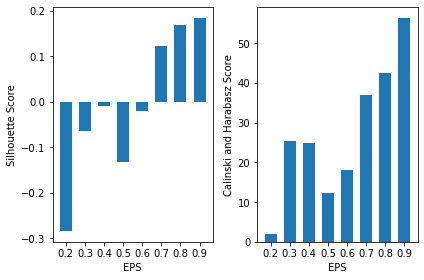

In [33]:
# Plotataan tulokset näkyville:

%matplotlib inline
import matplotlib.pyplot as plt

# Vasen puoli
plt.subplot(1, 2, 1)
plt.bar(dfB['EPS'],dfB['Silhouette_Score'],width=0.5/dfB['EPS'].shape[0])
plt.xlabel("EPS")
plt.xticks(dfB['EPS'])
plt.ylabel("Silhouette Score")


# Oikea puoli
plt.subplot(1, 2, 2)
plt.bar(dfB['EPS'],dfB['CH_score'],width=0.5/dfB['EPS'].shape[0])
plt.xlabel("EPS")
plt.xticks(dfB['EPS'])
plt.ylabel("Calinski and Harabasz Score")


plt.tight_layout()
plt.show()

### Bonustehtävä: Pyri löytämään visualisointimenetelmä klusteroidulle datalle, josta käy selkeämmin ilmi klusterit, joihin kukin algoritmi on datan klusteroinut
Luo kullekin klusterointi-algoritmille oma kuvaajansa, josta käy ilmi eri klusterit

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt


# Luodaan funktio jotta plottaus on helpompaa

def plotClusters(clusters, name):
    plt.scatter(data_standardized.iloc[:,4], data_standardized.iloc[:,3], c=clusters, s=10, cmap='jet', alpha=1)
    plt.xlabel('Grocery')
    plt.ylabel('Milk')

    plt.title(name)

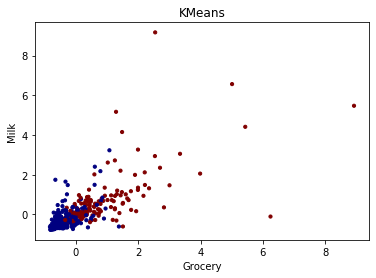

In [35]:
plotClusters(pred_kmeans,"KMeans")

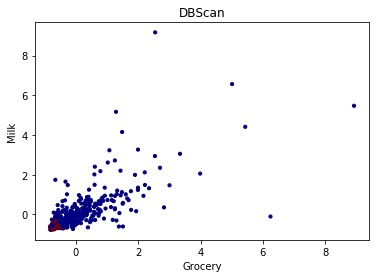

In [36]:
plotClusters(pred_dbscan,"DBScan")

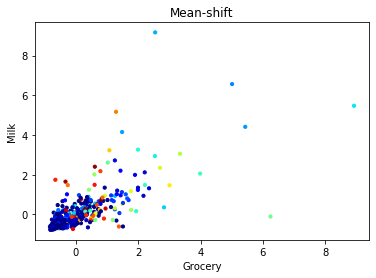

In [37]:
plotClusters(pred_meanshift,"Mean-shift")

### Kokeillaan 3d-plottausta
#### A. Standardisoidulla datalla

In [38]:
data_standardized

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.447005,0.589997,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,1.447005,0.589997,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050
2,1.447005,0.589997,-0.446521,0.408073,-0.028125,-0.137379,0.133080,2.240742
3,-0.689512,0.589997,0.099998,-0.623310,-0.392530,0.686363,-0.498021,0.093305
4,1.447005,0.589997,0.839284,-0.052337,-0.079266,0.173661,-0.231654,1.297870
...,...,...,...,...,...,...,...,...
435,-0.689512,0.589997,1.399719,0.847482,0.849793,2.072862,-0.566186,0.240817
436,-0.689512,0.589997,2.152842,-0.591469,-0.756304,0.296223,-0.584853,0.291170
437,1.447005,0.589997,0.200098,1.313176,2.345716,-0.542762,2.508362,0.121318
438,-0.689512,0.589997,-0.135230,-0.516947,-0.601829,-0.418964,-0.569122,0.212804


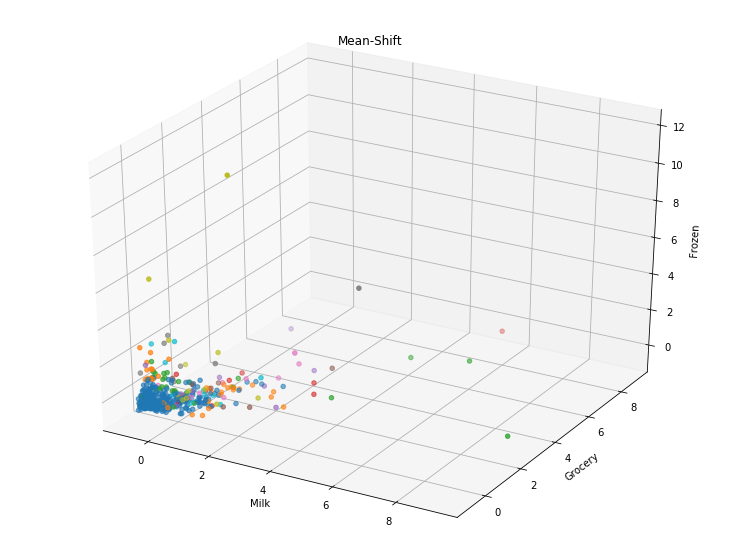

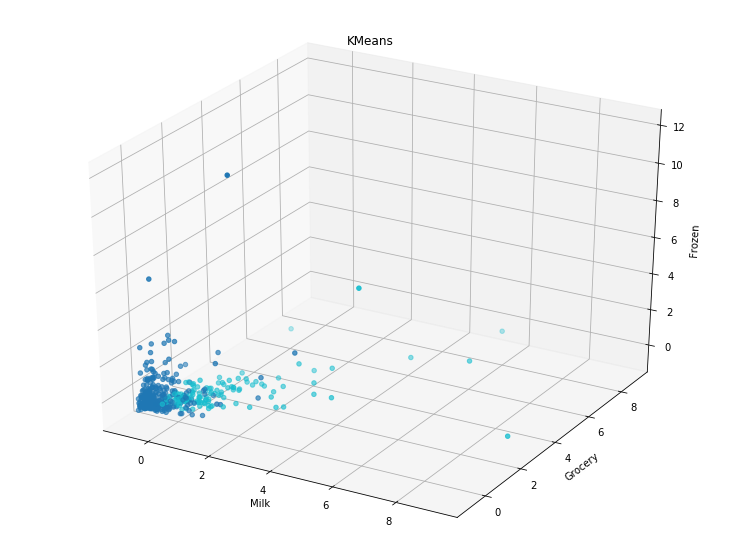

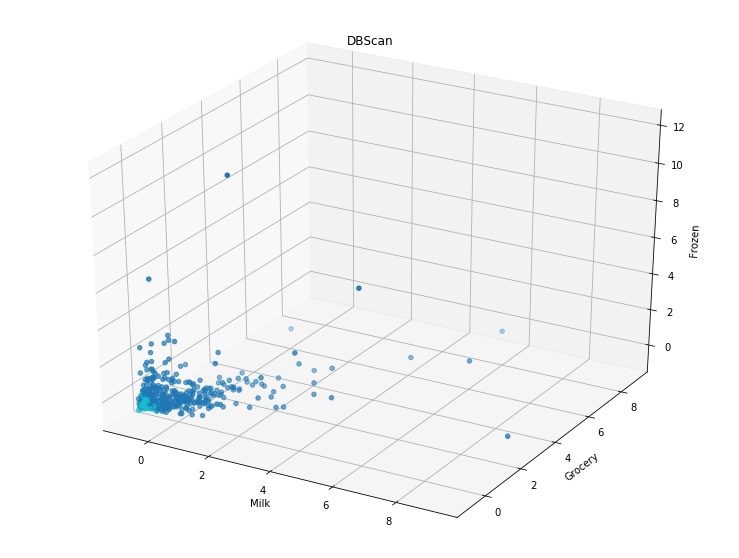

In [39]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

def threedeePlot(dataa,clusters,name):
    fig = plt.figure(figsize=(13,10))
    ax = plt.axes(projection='3d')

    ax.scatter(dataa.iloc[:,3], dataa.iloc[:,4], dataa.iloc[:,5], c=clusters, cmap='tab10')

    ax.set_xlabel('Milk')
    ax.set_ylabel('Grocery')
    ax.set_zlabel('Frozen')
    plt.title(name)
    plt.show()
    
threedeePlot(data_standardized,pred_meanshift,"Mean-Shift")
threedeePlot(data_standardized,pred_kmeans,"KMeans")
threedeePlot(data_standardized,pred_dbscan,"DBScan")

- Näistä ei kyllä oikein hahmota klustereita mitenkään. :(

#### B. Normalisoidulla datalla 3d-plottaus

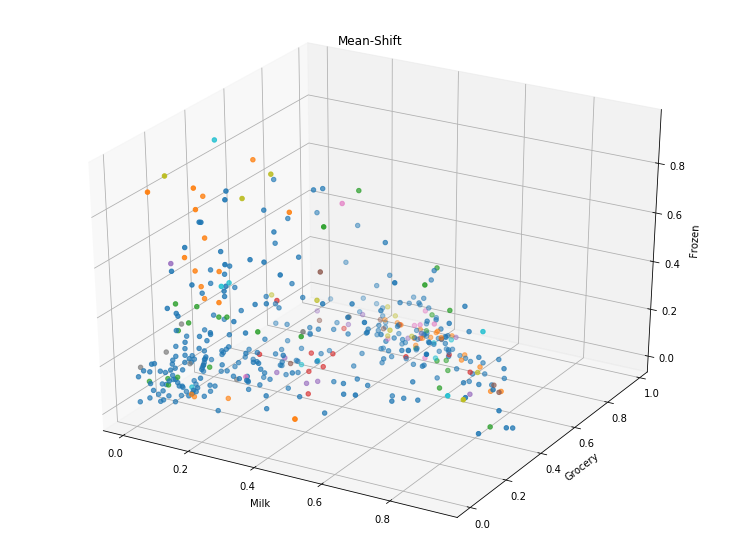

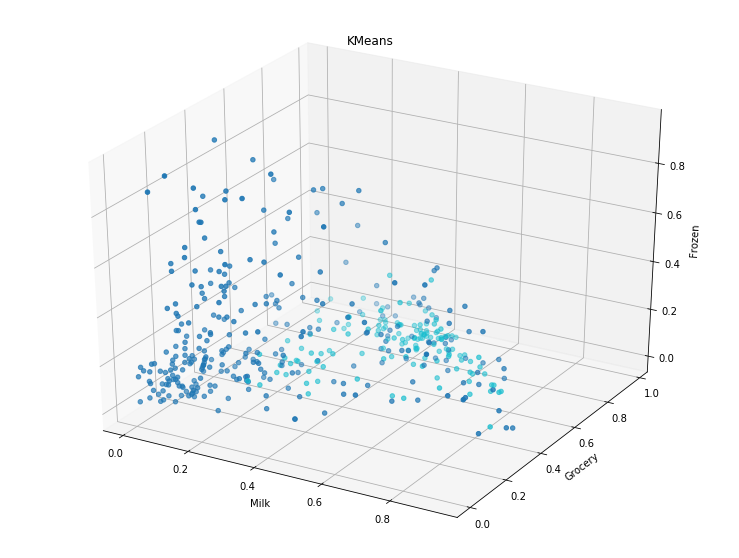

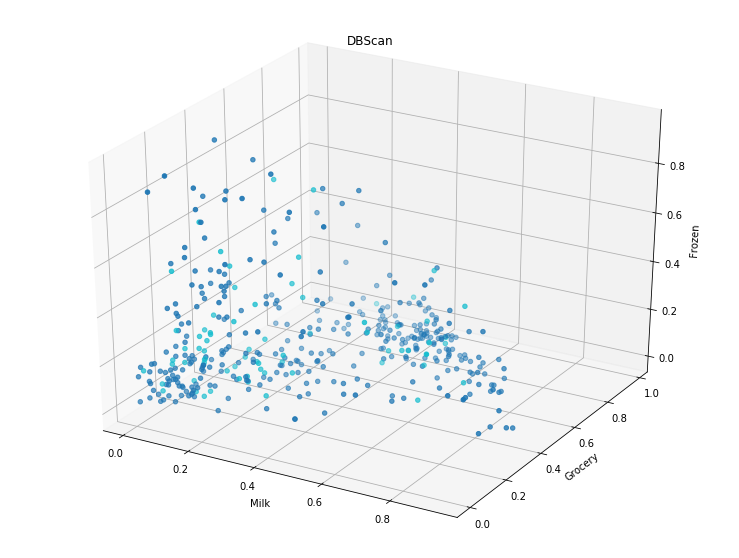

In [40]:
from sklearn.preprocessing import Normalizer

# Datan normalisointi
transformer = Normalizer().fit(data)
data_normalized = transformer.transform(data)
data_normalized_pd = pd.DataFrame(data=data_normalized)

# Plottaus
threedeePlot(data_normalized_pd,pred_meanshift,"Mean-Shift")
threedeePlot(data_normalized_pd,pred_kmeans,"KMeans")
threedeePlot(data_normalized_pd,pred_dbscan,"DBScan")

- Näistä erottaa klustereita vieläkin huonommin

#### c. PCA ja 3d-plottaus

- Kokeillaan vähentää dimensioita jos klusterit hahmottaisi sitten paremmin.

In [41]:
from sklearn.decomposition import PCA

# Vähennetään dimensioita kolmeen, jotta plottaus toimisi ehkä paremmin...
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(data_standardized)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

principalDf.head(3)

,principal component 1,principal component 2,principal component 3
0,0.842979,-0.514765,-0.766759
1,1.061468,-0.484050,-0.672210
2,1.267697,0.681279,-0.663340


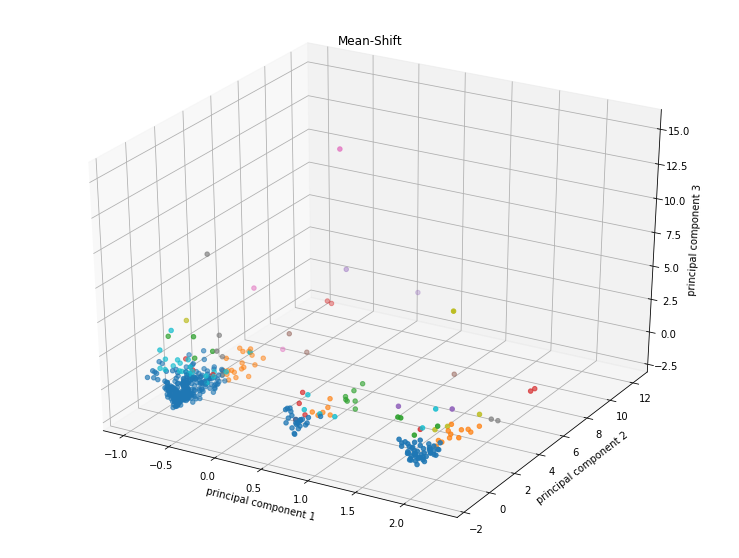

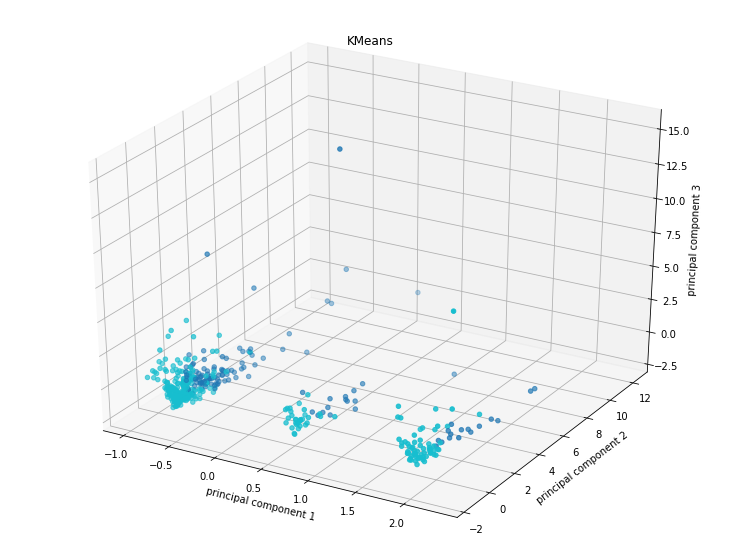

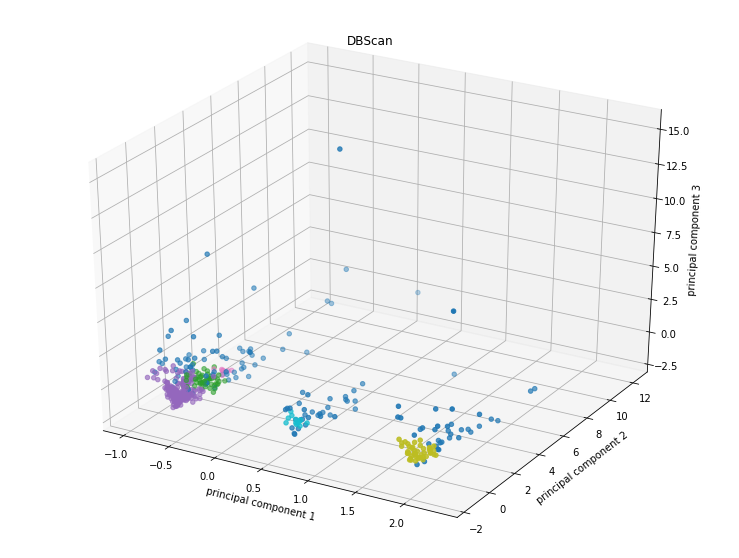

In [42]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Uusi 3d-plottaus
def threedeePlot2(clusters,name):
    fig = plt.figure(figsize=(13,10))
    ax = plt.axes(projection='3d')

    ax.scatter(principalDf.iloc[:,2], principalDf.iloc[:,0],principalDf.iloc[:,1], c=clusters, cmap='tab10')

    ax.set_xlabel('principal component 1')
    ax.set_ylabel('principal component 2')
    ax.set_zlabel('principal component 3')

    plt.title(name)
    plt.show()
    
# Tehdään uudet mallin sovitukset kaikille käyttäen pca:n läpi mennyttä dataa:

# MEANSHIFT
est_meanshift_pca = MeanShift(bandwidth=0.9)
est_meanshift_pca.fit(principalDf)
pred_meanshift_pca = est_meanshift_pca.predict(principalDf)

# KMEANS
est_kmeans_pca = KMeans(n_clusters=2)
est_kmeans_pca.fit(principalDf)
pred_kmeans_pca = est_kmeans_pca.predict(principalDf)

# DBSCAN
est_dbscan_pca = DBSCAN(eps=0.3)
pred_dbscan_pca = est_dbscan_pca.fit_predict(principalDf)
    
    
threedeePlot2(pred_meanshift_pca,"Mean-Shift")
threedeePlot2(pred_kmeans_pca,"KMeans")
threedeePlot2(pred_dbscan_pca,"DBScan")

### Lopputulos
- Nyt kuvasta pystyy jo näkemään jonkinlaisia klustereita.